# Loading Dependencies

In [1]:
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt

from numpy import array
import numpy as np
from scipy.io import loadmat
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

from math import sqrt
from numpy import array
from numpy import mean
from sklearn.metrics import mean_squared_error


from pandas import DataFrame
from pandas import concat
from pandas import read_csv

(125001, 1)
(125001, 1)
(125001, 1)


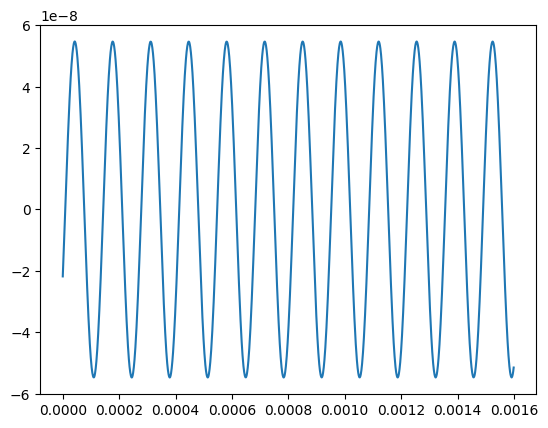

In [11]:
rec_time = 0.1
#rec_time = 60
sampling_rate = 1250000
start_time = 0
t_array = np.arange(start_time, rec_time, 1/sampling_rate)
t_array = np.array(t_array)
t_array = t_array[:,np.newaxis]

velocity_dataset = loadmat("datasel_7422Hz_Sin_800mSrec_4-40kHzfilter_0.449mA_pointfromtip_2.mat")
velocity_raw  = velocity_dataset["datasel"]
velocity = velocity_raw[:, 1]
velocity = np.array(velocity)
velocity = velocity[:,np.newaxis]


#displacement = simpson(velocity, t_array)
def calculate_displacement(velocity, sampling_rate):
    displacement_initial = []
    for i in range(len(velocity)):
        displacement = velocity[i] * (1/sampling_rate)
        displacement_initial = np.append(displacement_initial, displacement)
    
    return displacement_initial

displacement_initial = calculate_displacement(velocity, sampling_rate)

displacement = np.array(displacement_initial)
displacement = displacement[:,np.newaxis]

print(displacement.shape)
print(velocity.shape)
print(t_array.shape) 

#plt.plot(velocity)
plt.plot(t_array[:2000, 0], displacement[:2000, 0])

# Loading the Dataset

In [12]:
# # For voltage data
# data_file =loadmat("10filtered_700_13000.mat") 
# x_rec = data_file["low_filtered"]
# print(x_rec[1:5, 0])
# print(x_rec.shape)

# for displacement data
#data_file =loadmat("integrated displacement sine.mat") 
x_rec = displacement
print(x_rec[1:5, 0])
print(x_rec.shape)

[-1.9925096e-08 -1.8009952e-08 -1.6067488e-08 -1.4102384e-08]
(125001, 1)


# Split a univariate sequence into samples

In [18]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(x_rec[40000:42004, 0], n_steps)
# summarize the data
# for i in range(len(X)):
#  	print(X[i], y[i])
print(X.shape)
print(y.shape)

(2001, 3)
(2001,)


# Splitting in a generic way using Panda dataframe

In [4]:
""" # split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values """

' # split a univariate dataset into train/test sets\ndef train_test_split(data, n_test):\n\treturn data[:-n_test], data[-n_test:]\n\n# transform list into supervised learning format\ndef series_to_supervised(data, n_in, n_out=1):\n\tdf = DataFrame(data)\n\tcols = list()\n\t# input sequence (t-n, ... t-1)\n\tfor i in range(n_in, 0, -1):\n\t\tcols.append(df.shift(i))\n\t# forecast sequence (t, t+1, ... t+n)\n\tfor i in range(0, n_out):\n\t\tcols.append(df.shift(-i))\n\t# put it all together\n\tagg = concat(cols, axis=1)\n\t# drop rows with NaN values\n\tagg.dropna(inplace=True)\n\treturn agg.values '

# Loading the test_set for model evaluation

In [19]:
n_features = 1
# Validation data set 60k-63k.Test set varies
X_test, y_test = split_sequence(x_rec[112000:113004, 0], n_steps)
print(X_test.shape)
print(y_test.shape)

(1001, 3)
(1001,)


# Define model architecture

In [20]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=n_steps))
model.add(Dense(200, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X, y, epochs=3000, validation_data=(X_test, y_test), verbose=0)
#history = model.fit(trainX, trainY, epochs=50, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)
model.save('MLP_sine_final.hdf5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 200)               800       
                                                                 
 dense_7 (Dense)             (None, 200)               40200     
                                                                 
 dense_8 (Dense)             (None, 1)                 201       
                                                                 
Total params: 41,201
Trainable params: 41,201
Non-trainable params: 0
_________________________________________________________________


# Demonstrate prediction for Test/Training dataset

In [21]:
#input = X_test
input = X
prediction_list = []
for row in input:
    x_input = array(row)
    x_input = x_input.reshape((1, n_steps))
    
    # making predictions
    yhat = model.predict(x_input, verbose=0)
    prediction_list.append(yhat)
predicted_values = np.array(prediction_list)

# Plotting History

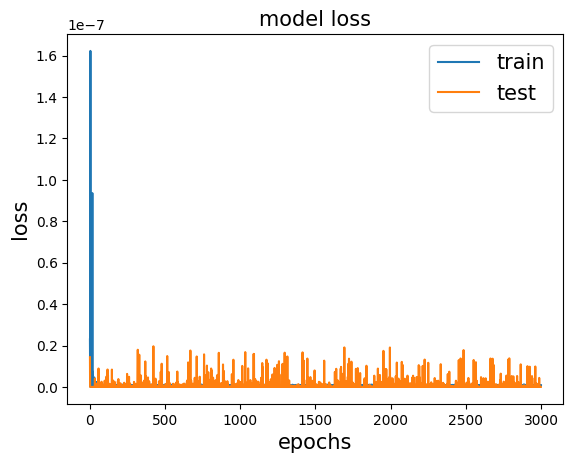

In [8]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
#pyplot.legend()

pyplot.title('model loss',size=15)
pyplot.ylabel('loss',size=15)
pyplot.xlabel('epochs',size=15)
pyplot.legend(loc='upper right',fontsize=15)

pyplot.show()

# Training and Model evaluation

In [22]:
R2_score_train = r2_score(X[4:, 0], predicted_values[0:-4, 0], force_finite=False)
R2_score_train = "{:.4f}".format(R2_score_train)
print(f"The observed R2_score for the training_set is:",R2_score_train)

# R2_score_test = r2_score(X_test[4:, 0], predicted_values[0:-4, 0], force_finite=False)
# R2_score_test = "{:.4f}".format(R2_score_test)
# print(f"The observed R2_score for the test_set is:",R2_score_test)

The observed R2_score for the training_set is: -288440.6591


# Plotting the evaluation

(3000, 1, 1)


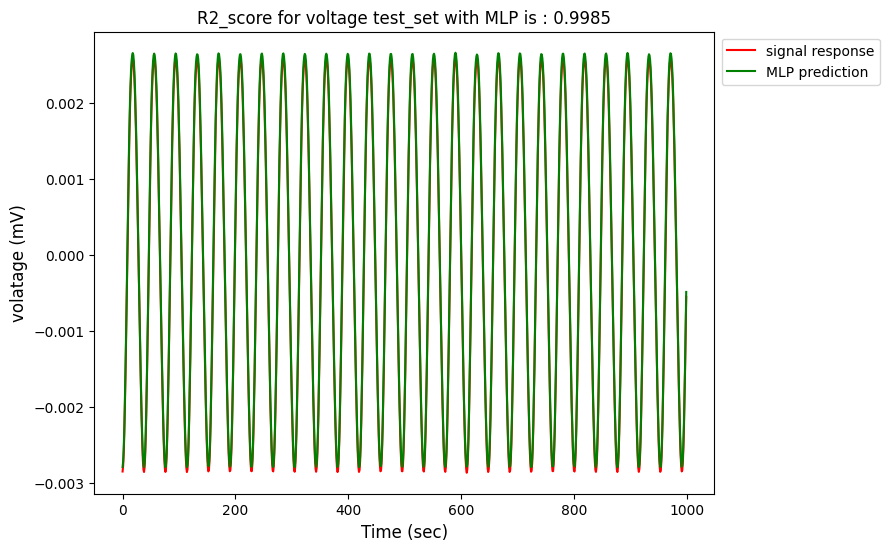

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(8,6))
ax.set_ylabel('volatage (mV)', fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
print(predicted_values.shape)

# For training set
# plt.plot (X[4:1004, 0], 'r', label="signal response")
# plt.plot(predicted_values[0:1000, 0], 'g', label= "MLP prediction")

# # For Laser data 
# ax.set_title(f'R2_score for displacement training_set is : {R2_score_train} ')

# # For voltage data
# ax.set_title(f'R2_score for voltage training_set with MLP is : {R2_score_train}')
 
# For test_set
plt.plot (X_test[4:1004, 0], 'r', label="signal response")
plt.plot(predicted_values[0:1000, 0], 'g', label= "MLP prediction")

# # For Laser data 
# ax.set_title(f'R2_score for displacement test set with MLP is : {R2_score_test}')

#For voltage data
ax.set_title(f'R2_score for voltage test_set with MLP is : {R2_score_test}')

ax.legend(loc='upper left', bbox_to_anchor=(1.0005, 1))

# Perform GridSearch for Hyperparameters tuning!

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]

# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# define model
	model = Sequential()
	model.add(Dense(n_nodes[0], activation='relu', input_dim=n_input))
	model.add(Dense(n_nodes[1], activation='relu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(optimizer='adam', loss='mse')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# shape input for model
	x_input = array(history[-n_input:]).reshape((1, n_input))
	# make forecast
	yhat = model.predict(x_input, verbose=0)
	# correct forecast if it was differenced
	return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.4f' % error)
	return error

# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=5):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.4f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [3, 4]
	n_nodes = [(50,100), (100, 100), (100, 150)]
	n_epochs = [500, 1000, 1500]
	n_batch = [32]
	n_diff = [0]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

# define dataset
data = x_rec[40000:51000]
# data split
n_test = 1000
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
	print(cfg, error)

Total configs: 18
 > 0.0004
 > 0.0002
 > 0.0004
 > 0.0095
 > 0.0021
> Model[[3, (50, 100), 500, 32, 0]] 0.0025
 > 0.0014
 > 0.0004
 > 0.0002
 > 0.0011
 > 0.0007
> Model[[3, (50, 100), 1000, 32, 0]] 0.0007
 > 0.0001
 > 0.0003
 > 0.0002
 > 0.0011
 > 0.0043
> Model[[3, (50, 100), 1500, 32, 0]] 0.0012
 > 0.0048
 > 0.0016
 > 0.0002
 > 0.0008
 > 0.0006
> Model[[3, (100, 100), 500, 32, 0]] 0.0016
 > 0.0001
 > 0.0005
 > 0.0042
 > 0.0006
 > 0.0005
> Model[[3, (100, 100), 1000, 32, 0]] 0.0012
 > 0.0003
 > 0.0002
 > 0.0001
 > 0.0002
 > 0.0005
> Model[[3, (100, 100), 1500, 32, 0]] 0.0003
 > 0.0011
 > 0.0002
 > 0.0004
 > 0.0039
 > 0.0001
> Model[[3, (100, 150), 500, 32, 0]] 0.0011
 > 0.0001
 > 0.0005


: 

: 

# Saving the  search result to a file for future if needed

In [ ]:
# Convert the scores to a string representation
scores_str = str(scores)

# Specify the file path and name
file_path = 'scores for different layer size.txt'

# Open the file in write mode and write the scores
with open(file_path, 'w') as file:
    file.write(scores_str)

# Plotting the results for different parameters

a. Size of the Layer

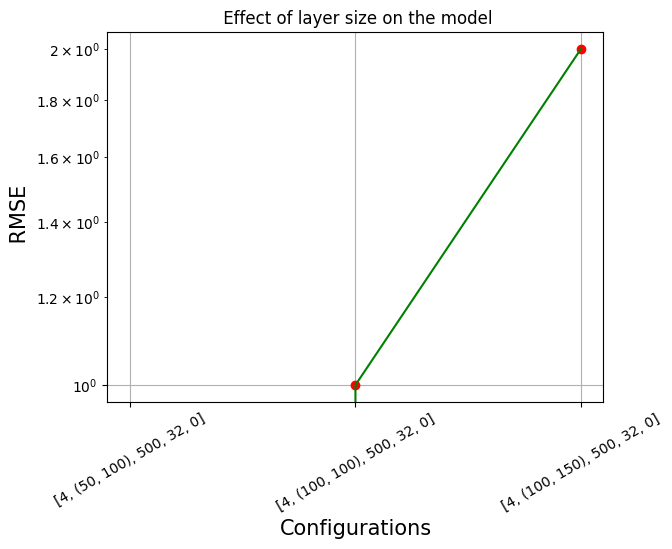

In [ ]:
scores = np.array(scores)
plt.figure()
plt.semilogy(scores[:, 0], scores[:, 1], "ro")
plt.semilogy(scores[:, 0], scores[:, 1], "g")
plt.title(" Effect of layer size on the model")
plt.ylabel(r" RMSE", fontsize=15)
plt.xlabel(r"Configurations", fontsize=15)
plt.xticks(fontsize=10, rotation=30)
plt.yticks(fontsize=10)
plt.grid(True)

b. Input size (series to supervised)

In [ ]:
# scores = np.array(scores)
# # Plot the data
# plt.figure()
# plt.semilogy(scores[:, 0], scores[:, 1], "ro")
# plt.semilogy(scores[:, 0], scores[:, 1], "g")
# plt.title(" Effect of input_size size on the model")
# plt.ylabel(r" RMSE", fontsize=15)
# plt.xlabel(r"Configurations", fontsize=15)
# plt.xticks(fontsize=10, rotation=30)
# plt.yticks(fontsize=10)
# plt.grid(True)

c. Number of epochs

In [ ]:
scores = np.array(scores)
plt.figure()
plt.semilogy(scores[:, 0], scores[:, 1], "ro")
plt.semilogy(scores[:, 0], scores[:, 1], "g")
plt.title(" Effect of number of epochs on the model")
plt.ylabel(r" RMSE", fontsize=15)
plt.xlabel(r"Configurations", fontsize=15)
plt.xticks(fontsize=10, rotation=30)
plt.yticks(fontsize=10)
plt.grid(True)

NameError: name 'scores' is not defined

Check the computational efficiency